In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist
from skfuzzy.cluster import cmeans
import time

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist
from skfuzzy.cluster import cmeans
import time

def extract_clusters(image_path, n_clusters, m=2.0, max_iter=150, error=1e-5, spatial_weight=0.1):
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    reshaped_image = image.reshape(-1, 3).astype(np.float64)  # shape: (N, 3)

    # Generate normalized spatial coordinates
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    xx = (xx.flatten() / w).reshape(-1, 1)
    yy = (yy.flatten() / h).reshape(-1, 1)
    spatial_features = spatial_weight * np.hstack((xx, yy))  # shape: (N, 2)

    # Combine RGB + spatial
    features = np.hstack((reshaped_image, spatial_features))  # shape: (N, 5)
    print(f"[INFO] Feature shape: {features.shape} (RGB + normalized XY coordinates)")

    # Step 1: K-Means Initialization
    print("[INFO] Running K-Means for initialization...")
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(features)
    kmeans_labels = kmeans.labels_

    # Step 2: Fuzzy C-Means Clustering
    print("[INFO] Running Fuzzy C-Means with K-Means initialization...")
    start_time = time.time()

    data_for_fcm = features.T  # shape: (5, N)
    n_points = data_for_fcm.shape[1]

    # Membership initialization
    u_init = np.zeros((n_clusters, n_points), dtype=np.float64)
    for i in range(n_points):
        assigned_cluster = kmeans_labels[i]
        u_init[assigned_cluster, i] = 0.9
        for j in range(n_clusters):
            if j != assigned_cluster:
                u_init[j, i] = 0.1 / (n_clusters - 1)

    # Normalize membership matrix
    column_sums = np.sum(u_init, axis=0)
    u_init /= column_sums[np.newaxis, :]

    # Run FCM
    centers, u, _, _, _, _, _ = cmeans(
        data=data_for_fcm,
        c=n_clusters,
        m=m,
        error=error,
        maxiter=max_iter,
        init=u_init
    )
    end_time = time.time()
    print(f"[INFO] FCM Converged in {end_time - start_time:.2f} seconds")

    # Assign labels from FCM memberships
    labels = np.argmax(u, axis=0)

    # Extract only RGB components from centers for visualization
    rgb_centers = centers[:, :3]
    rgb_centers = np.nan_to_num(rgb_centers, nan=0.0, posinf=255.0, neginf=0.0)
    rgb_centers = np.clip(rgb_centers, 0, 255).astype(np.uint8)

    # Prepare visualization
    combined_image = np.zeros_like(reshaped_image, dtype=np.uint8)
    fig_width = max(25, (n_clusters + 2) * 3)
    fig, axes = plt.subplots(1, n_clusters + 2, figsize=(fig_width, 10))
    fig.suptitle("Hybrid Clustering: KMeans Init + Fuzzy C-Means", fontsize=24)

    # Plot original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Original Image", fontsize=16)

    # Plot clusters
    for cluster_id in range(n_clusters):
        mask = (labels == cluster_id)
        cluster_image = np.zeros_like(reshaped_image, dtype=np.uint8)
        cluster_image[mask] = rgb_centers[cluster_id]
        combined_image[mask] = rgb_centers[cluster_id]

        cluster_image_reshaped = cluster_image.reshape(h, w, 3)
        axes[cluster_id + 1].imshow(cluster_image_reshaped)
        axes[cluster_id + 1].axis('off')
        axes[cluster_id + 1].set_title(f"Cluster {cluster_id}\nColor: {rgb_centers[cluster_id]}", fontsize=14)
        print(f"Cluster {cluster_id} Center Color: {rgb_centers[cluster_id]}")

    # Show combined image
    combined_image_reshaped = combined_image.reshape(h, w, 3)
    axes[-1].imshow(combined_image_reshaped)
    axes[-1].axis('off')
    axes[-1].set_title("Combined Cluster Image", fontsize=16)

    # Display plot
    plt.tight_layout()
    try:
        plt.show()
    except Exception as e:
        print(f"[WARNING] Could not display plot: {e}")

    # Compute clustering metrics
    try:
        if len(np.unique(labels)) > 1:
            dbi = davies_bouldin_score(reshaped_image, labels)
            silhouette = silhouette_score(reshaped_image, labels)
        else:
            dbi = float('inf')
            silhouette = -1.0
            print("[WARNING] Only one cluster found, metrics may be invalid")
        wcss = np.sum(np.min(cdist(reshaped_image, rgb_centers, 'euclidean'), axis=1) ** 2)

        print("\nCluster Quality Metrics:")
        print(f"Davies-Bouldin Index (DBI): {dbi:.4f}")
        print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")
        print(f"Silhouette Score: {silhouette:.4f}")
    except Exception as e:
        print(f"[ERROR] Could not compute metrics: {e}")
        dbi = wcss = silhouette = None

    return rgb_centers, labels.reshape(h, w), combined_image_reshaped, image


[INFO] Feature shape: (50176, 5) (RGB + normalized XY coordinates)
[INFO] Running K-Means for initialization...
[INFO] Running Fuzzy C-Means with K-Means initialization...
[INFO] FCM Converged in 1.98 seconds
Cluster 0 Center Color: [102  50   0]
Cluster 1 Center Color: [1 1 0]
Cluster 2 Center Color: [183  84   0]
Cluster 3 Center Color: [126  60   0]
Cluster 4 Center Color: [74 38  0]


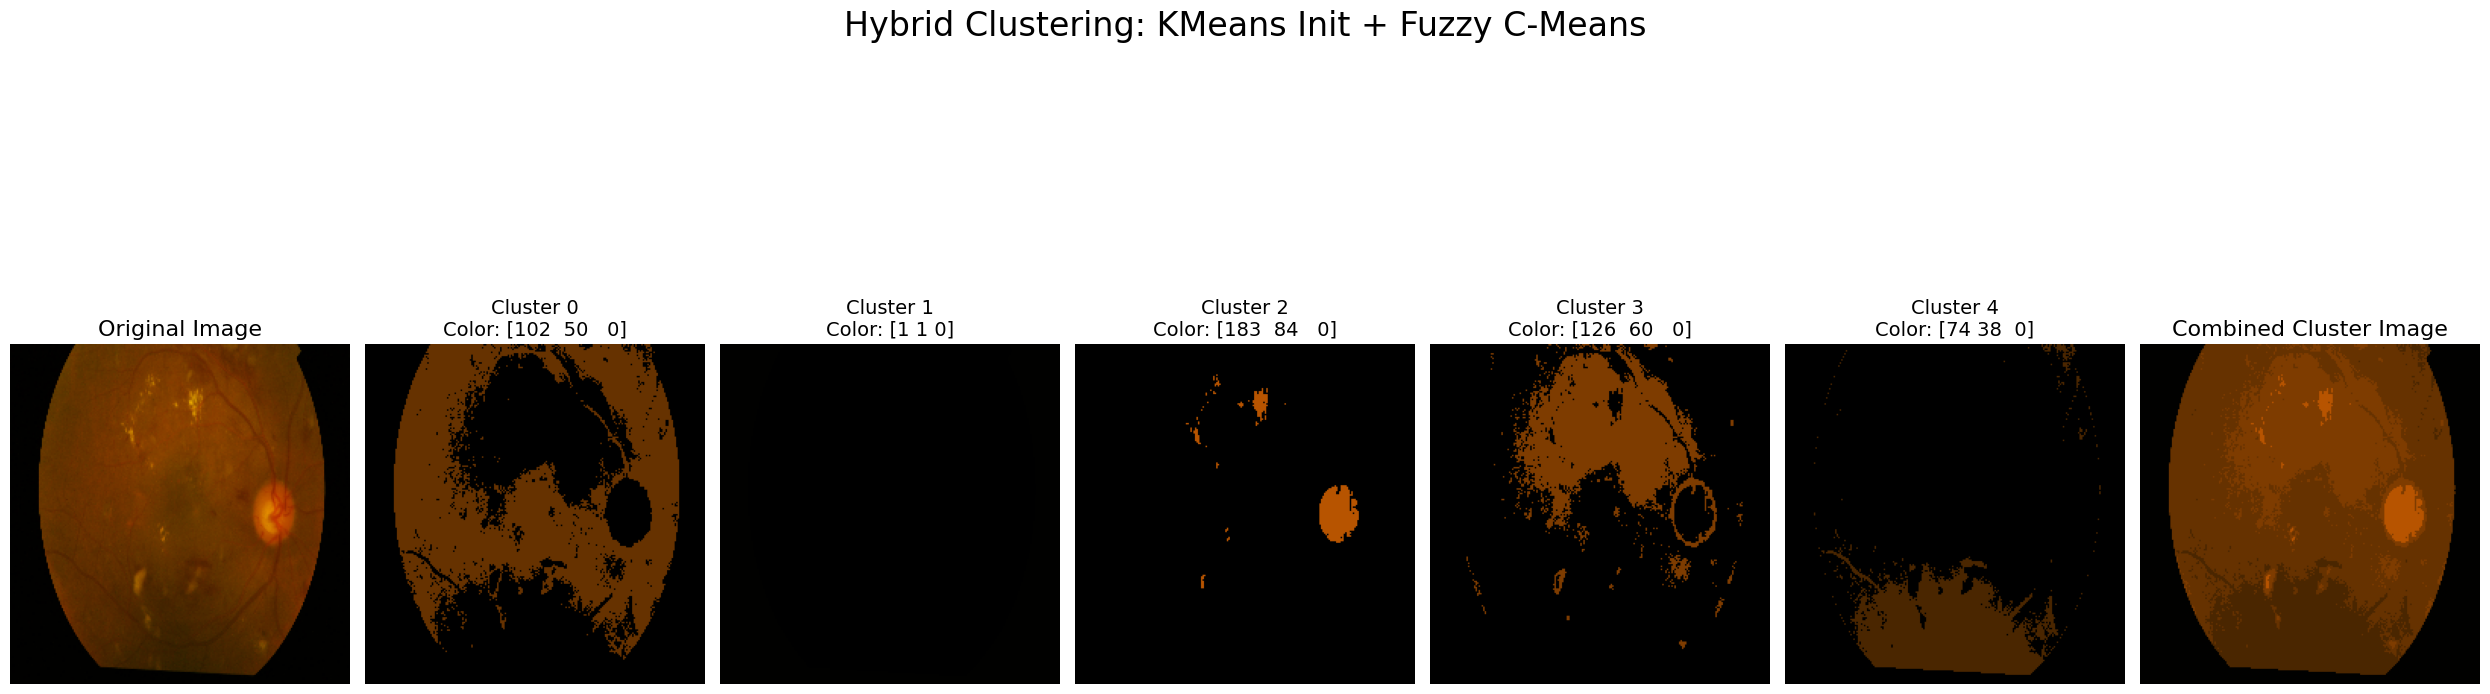


Cluster Quality Metrics:
Davies-Bouldin Index (DBI): 0.4858
Within-Cluster Sum of Squares (WCSS): 3851497.0000
Silhouette Score: 0.6538


In [3]:
# Step 1: Extract Clusters
centers, labels, clustered_image, original_image = extract_clusters('DR2_no_blue.png', n_clusters=5, spatial_weight=0.05)

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_cluster(original_image, labels, target_cluster_id, brightness=0, contrast=0):
    h, w, c = original_image.shape
    reshaped_image = original_image.reshape(-1, 3)
    enhanced_image = reshaped_image.copy()
    
    # Flatten labels to match reshaped_image
    flat_labels = labels.reshape(-1)
    
    # Create mask for the cluster
    mask = (flat_labels == target_cluster_id)
    cluster_pixels = reshaped_image[mask]

    # Brightness and contrast adjustment
    alpha = 1 + (contrast / 100.0)  # Contrast scaling
    beta = int(brightness)          # Brightness offset
    enhanced_pixels = cv2.convertScaleAbs(cluster_pixels, alpha=alpha, beta=beta)

    # Replace original cluster pixels with enhanced ones
    enhanced_image[mask] = enhanced_pixels
    enhanced_image = enhanced_image.reshape(h, w, 3)

    # Plotting
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image", fontsize=18)

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image)
    plt.axis('off')
    plt.title(f"Enhanced Cluster {target_cluster_id} (B:{brightness}, C:{contrast})", fontsize=18)

    plt.tight_layout()
    plt.show()

    return enhanced_image

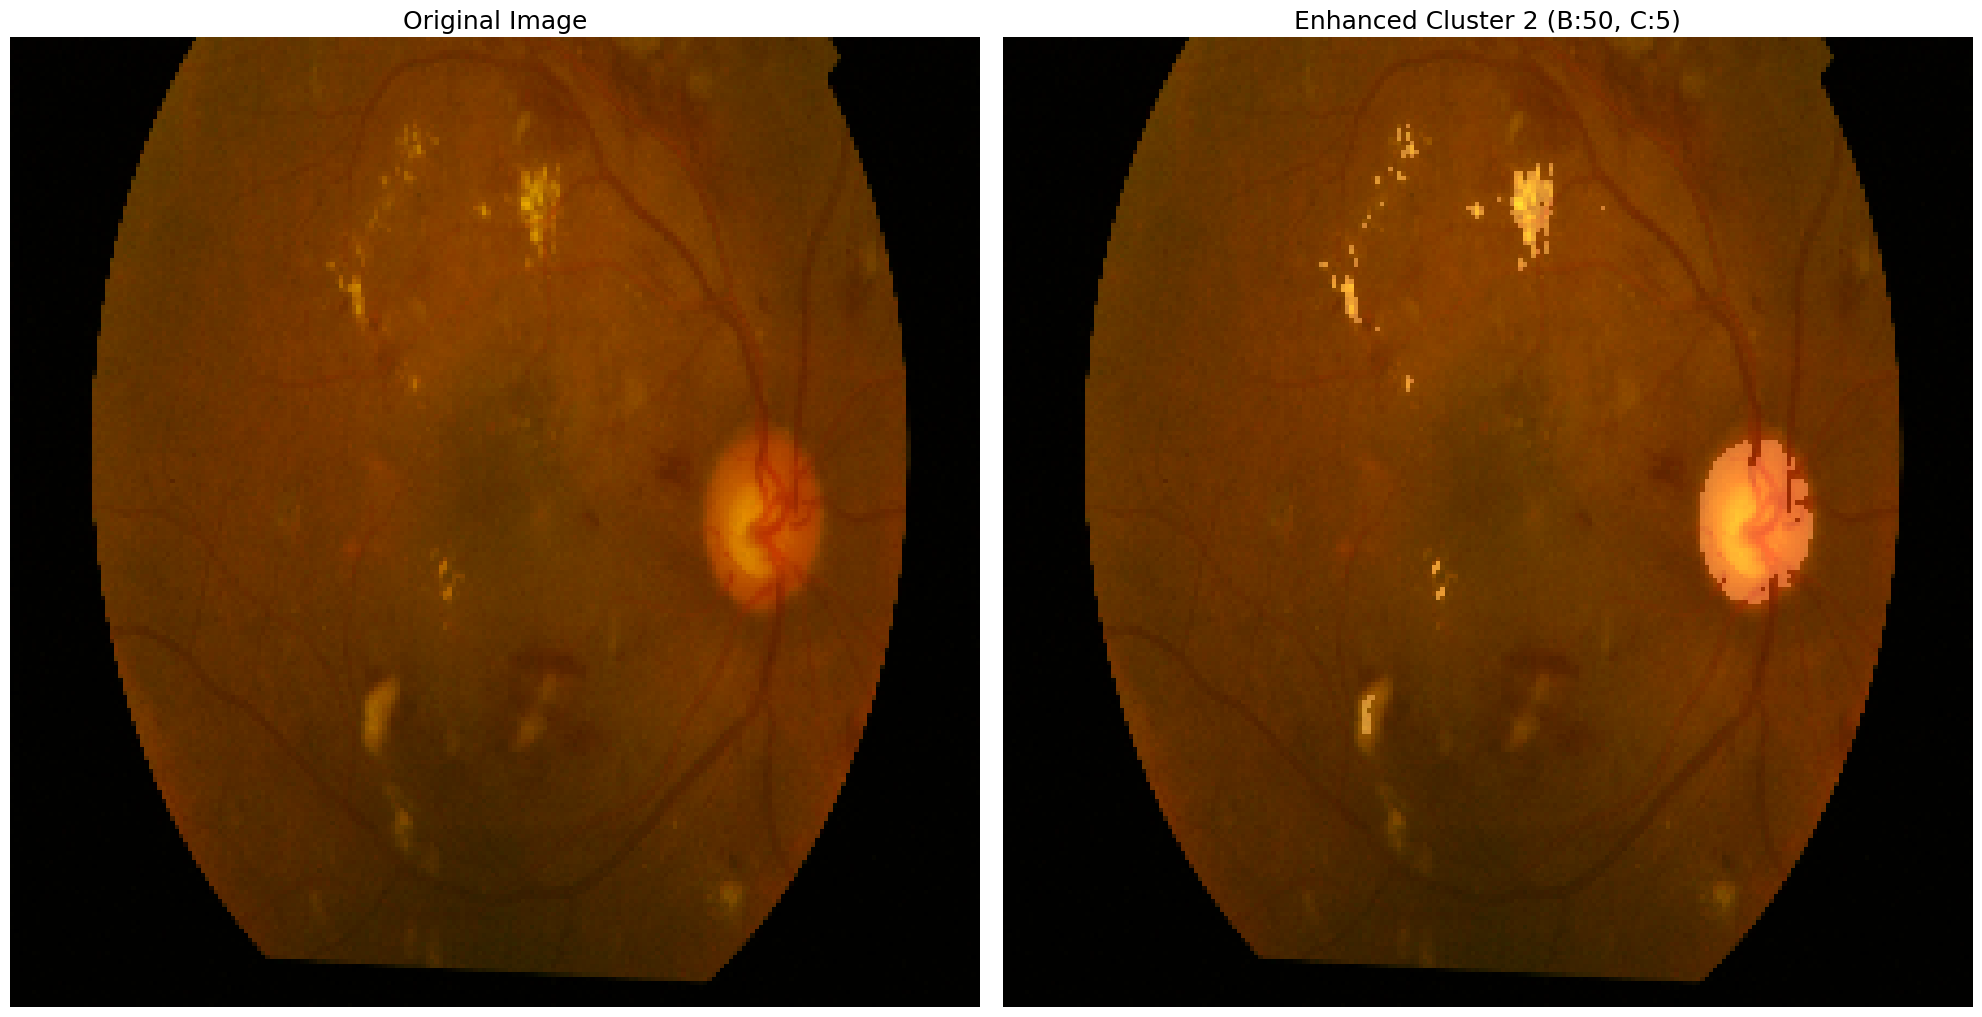

In [8]:
#  Enhance cluster 1 with brightness +30 and contrast +40
enhanced = enhance_cluster(original_image, labels, target_cluster_id=2, brightness=50, contrast=5)

[INFO] Feature shape: (50176, 5) (RGB + normalized XY coordinates)
[INFO] Running K-Means for initialization...
[INFO] Running Fuzzy C-Means with K-Means initialization...
[INFO] FCM Converged in 1.65 seconds
Cluster 0 Center Color: [102  50  14]
Cluster 1 Center Color: [1 1 1]
Cluster 2 Center Color: [74 38 12]
Cluster 3 Center Color: [182  84  14]
Cluster 4 Center Color: [126  60  14]


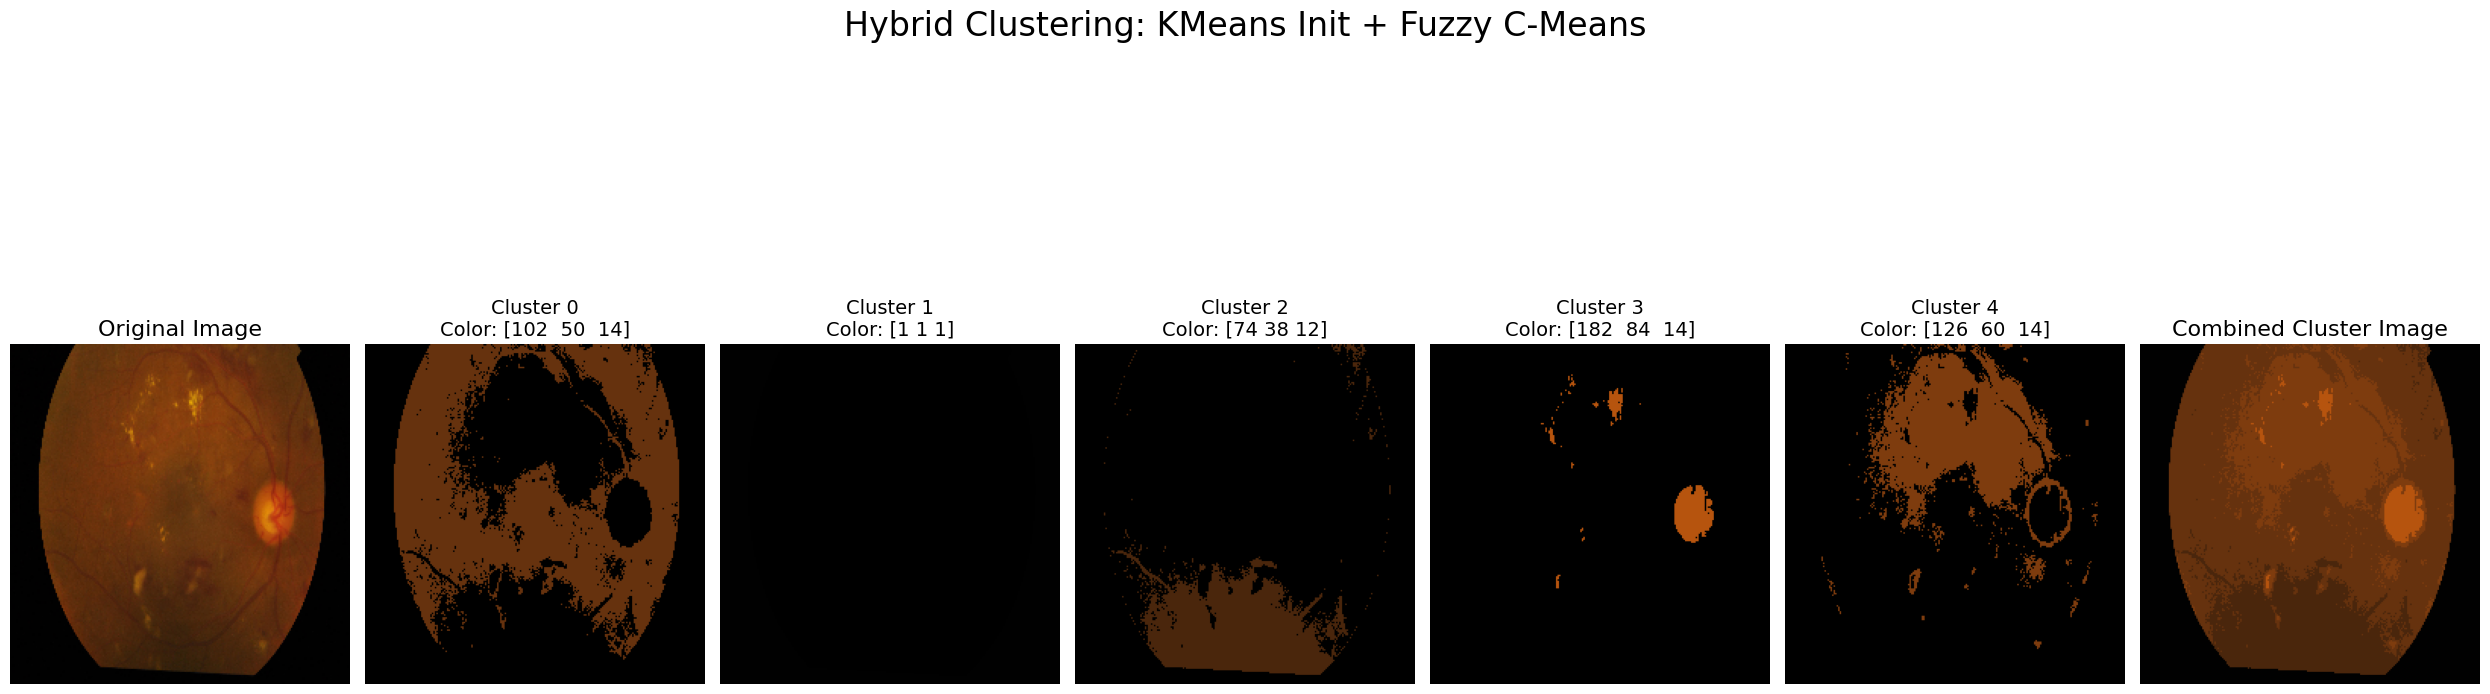


Cluster Quality Metrics:
Davies-Bouldin Index (DBI): 0.5051
Within-Cluster Sum of Squares (WCSS): 4060983.0000
Silhouette Score: 0.6409


In [12]:
# Step 1: Extract Clusters
centers, labels, clustered_image, original_image = extract_clusters('DR2.png', n_clusters=5, spatial_weight=0.05)

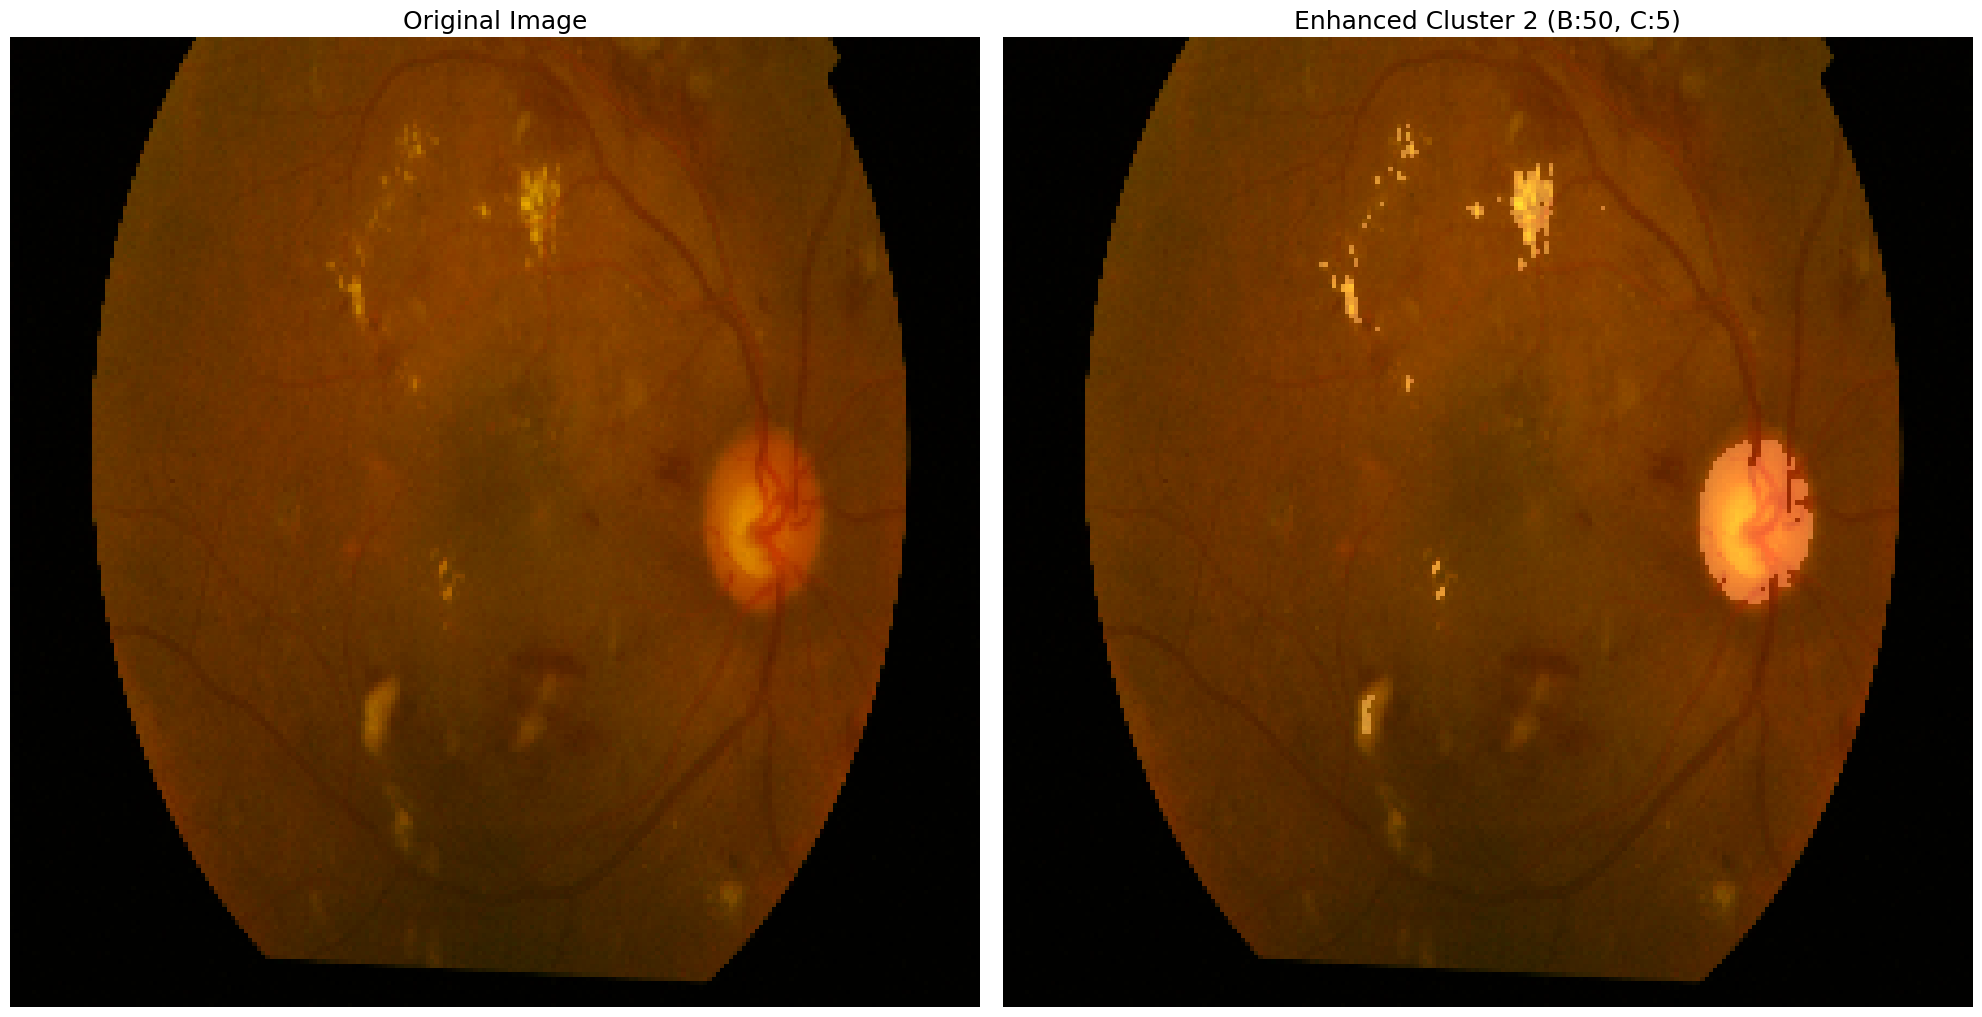

In [11]:
#  Enhance cluster 1 with brightness +30 and contrast +40
enhanced = enhance_cluster(original_image, labels, target_cluster_id=2, brightness=50, contrast=5)